In [110]:
## La couche d'encodage est le label

In [2]:
import tensorflow as tf
import numpy as np

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
NB_LABEL = 10

In [5]:
def weight_variable(shape):
    stddev = np.sqrt(1. / np.prod(shape[:-1]))
    print(stddev)
    initial = tf.random_normal(shape, stddev = stddev)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0., shape=shape)
    return tf.Variable(initial)

In [6]:
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')


In [7]:
x = tf.placeholder(tf.float32, [None, 784])
y_ = tf.placeholder(tf.float32, [None, NB_LABEL])

In [8]:
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

0.2


In [9]:
x_image = tf.reshape(x, [-1, 28, 28, 1])

In [10]:
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

In [11]:
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

0.0353553390593


In [12]:
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

0.0178571428571


In [77]:
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_logit = tf.matmul(h_fc1, W_fc2) + b_fc2

0.03125


In [95]:
indices = tf.argmax(y_logit, 1)

# multinomial softmax draw
#indices = tf.multinomial(y_logit, 1)[:,0]

depth = NB_LABEL
y_hat = tf.one_hot(indices, depth)

### Decoder

In [96]:
'''W_fc3 = weight_variable([10, 1024])
b_fc3 = bias_variable([1024])

#h_decoder = tf.nn.relu(tf.matmul(tf.nn.softmax(y_logit), W_fc3) + b_fc3)
h_decoder = tf.nn.relu(tf.matmul(y_hat * y_logit, W_fc3) + b_fc3)
#h_decoder = tf.matmul(y_hat, W_fc3) + b_fc3

W_fc4 = weight_variable([1024, 784])
b_fc4 = bias_variable([784])

x_gen = tf.matmul(h_decoder, W_fc4) + b_fc4'''


W_fc3 = weight_variable([10, 784])
b_fc3 = bias_variable([784])
#x_gen = tf.matmul(tf.nn.softmax(y_logit), W_fc3) + b_fc3
x_gen = tf.matmul(y_hat, W_fc3) + b_fc3

#x_gen = tf.matmul(y_hat * y_logit, W_fc3) + b_fc3


0.316227766017


In [97]:
correct_prediction = tf.cast(tf.equal(indices, tf.argmax(y_, 1)), tf.float32)
reward = correct_prediction - (1 - correct_prediction)
#reward_KL_plus = 1 #correct_prediction
#reward_KL_moins = 1 - correct_prediction

In [113]:
#cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))

p = tf.nn.softmax(y_logit)
q = 1. / NB_LABEL

#KL = tf.reduce_sum(p * y_logit,reduction_indices=1)
KL_ref = tf.reduce_sum(p * tf.log(p/q), reduction_indices=1)
KL = tf.reduce_mean(KL_ref) # + reward_KL_moins * (- tf.log(0.1) - KL_ref))
#KL = tf.nn.softmax_cross_entropy_with_logits(labels=y_hat, logits=y_logit) #!! KL(1_\hat{y})
#KL = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_logit)) #!! KL(1_\hat{y})

#cross_entropy_loss = tf.reduce_mean(reward * tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=x_gen, labels=x), reduction_indices=1))
#reward = 1
cross_entropy_loss = tf.reduce_mean(reward  * tf.nn.softmax_cross_entropy_with_logits(labels=y_hat, logits=y_logit)) 
#cross_entropy_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=x_gen, labels=x))

reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=x_gen, labels=x), reduction_indices = 1))
#rewarded_loss = reward * (KL + cross_entropy_loss)

rewarded_loss = KL +  cross_entropy_loss + reconstruction_loss
                              
train_step = tf.train.AdamOptimizer(1e-4).minimize(rewarded_loss)
accuracy = tf.reduce_mean(correct_prediction)



In [114]:
sess = tf.InteractiveSession()

In [115]:
#sess.run(KL, feed_dict={x: batch[0], y_: batch[1]})
#sess.run(reward, feed_dict={x: batch[0], y_: batch[1]})


In [116]:
#sess.run(rewarded_cross_entropy, feed_dict={x: batch[0], y_: batch[1]})

In [117]:
sess.run(tf.global_variables_initializer())

In [118]:
for i in range(20000):
    batch = mnist.train.next_batch(50)
    #print(reward.eval(feed_dict={x: batch[0], y_: batch[1]}))
    if i % 100 == 0:
        train_accuracy = accuracy.eval(feed_dict={x: batch[0], y_: batch[1]}) #, keep_prob: 1.0})
        consistency_loss = np.mean(KL.eval(feed_dict={x: batch[0], y_: batch[1]})) #, keep_prob: 1.0})
        code_loss = np.mean(cross_entropy_loss.eval(feed_dict={x: batch[0], y_: batch[1]})) #, keep_prob: 1.0})
        reco_loss = np.mean(reconstruction_loss.eval(feed_dict={x: batch[0], y_: batch[1]})) #, keep_prob: 1.0})
        print('step %d, training accuracy %g, consistency loss : %g, code_loss %g, reconstr_loss %g' % (i, train_accuracy, consistency_loss, code_loss,  reco_loss))
    train_step.run(feed_dict={x: batch[0], y_: batch[1]}) #, keep_prob: 0.5})



step 0, training accuracy 0.06, consistency loss : 0.0205483, code_loss 1.7758, reconstr_loss 548.867
step 100, training accuracy 0.04, consistency loss : 0.432793, code_loss 0.712531, reconstr_loss 541.835
step 200, training accuracy 0, consistency loss : 0.396588, code_loss 0.830146, reconstr_loss 536.305
step 300, training accuracy 0.02, consistency loss : 0.445322, code_loss 0.742415, reconstr_loss 531.635
step 400, training accuracy 0.02, consistency loss : 0.452554, code_loss 0.723885, reconstr_loss 526.639
step 500, training accuracy 0.02, consistency loss : 0.396624, code_loss 0.785921, reconstr_loss 520.504
step 600, training accuracy 0, consistency loss : 0.460149, code_loss 0.75365, reconstr_loss 515.874
step 700, training accuracy 0, consistency loss : 0.409934, code_loss 0.806141, reconstr_loss 509.675
step 800, training accuracy 0.02, consistency loss : 0.488357, code_loss 0.675602, reconstr_loss 505.384


KeyboardInterrupt: 

In [119]:
#cross_entropy_loss.eval(feed_dict={x: batch[0], y_: batch[1]})
indices.eval(feed_dict={x: batch[0], y_: batch[1]})

array([3, 3, 4, 3, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       4, 3, 3, 3])

In [120]:
print('test accuracy %g' % accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels}))


test accuracy 0.0044


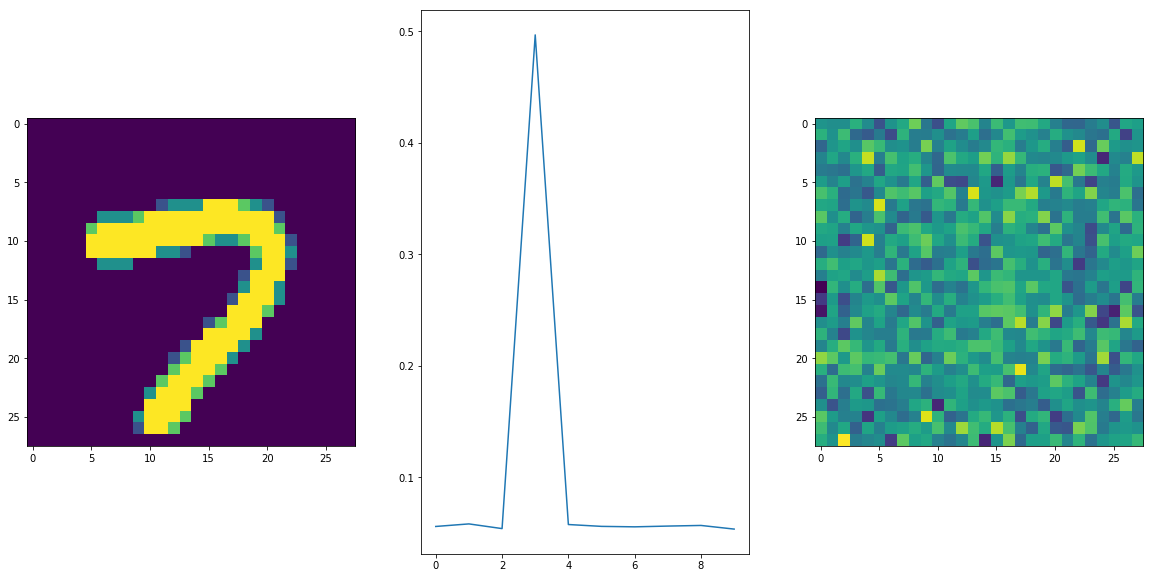

In [122]:
%matplotlib inline
import matplotlib.pyplot as plt
code = sess.run(tf.nn.softmax(y_logit), feed_dict={x: batch[0], y_: batch[1]})
pred = sess.run(x_gen, feed_dict={x: batch[0], y_: batch[1]})
i = 0
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(np.reshape(batch[0][i],(28, 28)))
plt.subplot(1,3,2)
plt.plot(code[i])
plt.subplot(1,3,3)
plt.imshow(np.reshape(pred[i],(28, 28)))



In [ ]:
reward

In [ ]:
sess.run((tf.multinomial(y_logit, 1)[:,0], indices), feed_dict={x: batch[0], y_: batch[1]})

In [ ]:
-np.log(0.1)